### Data analysis

In [1]:
import pandas as pd

casting_df = pd.read_csv('data/dataset2.csv')
casting_df.columns = casting_df.iloc[0]
casting_df = casting_df[1:].reset_index(drop=True)
casting_df = casting_df.iloc[2:]

casting_df.head()

,number,date,height_1,height_2,height_3,width_1,width_2,width_3,temp,bed_temp,humidity,layer_count,slicer_layer_height,slicer_layer_width,slicer_nozzle_speed,slicer_extrusion_multiplier
2,3,31.10.2024,"0,65","0,75","0,82","1,75","1,96","1,75","18,5",NaN,41%,1,"0,8","1,5",10,1
3,4,31.10.2024,"0,78","0,87","0,84","2,21","1,77","2,14","18,5",NaN,41%,1,"0,8","1,5",10,1
4,5,31.10.2024,"0,86","0,78","0,89","1,96","1,85","1,93","18,5",NaN,41%,1,"0,8","1,5",10,1
5,6,31.10.2024,"0,85","0,86","0,98","2,17","1,93","1,9","18,5",NaN,41%,1,"0,8","1,5",10,1
6,7,31.10.2024,"0,81","0,94","0,91","2,25","2,05","2,07","18,5",NaN,41%,1,"0,8","1,5",10,1


In [2]:
casting_df.drop(columns=['bed_temp', 'date', 'number', 'layer_count'], inplace=True)
casting_df['humidity'] = casting_df['humidity'].str.rstrip('%').astype('float') / 100.0

casting_df.dropna(inplace=True)

# Replace commas with dots and convert to float
casting_df = casting_df.map(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else float(x))

casting_df.head()

,height_1,height_2,height_3,width_1,width_2,width_3,temp,humidity,slicer_layer_height,slicer_layer_width,slicer_nozzle_speed,slicer_extrusion_multiplier
2,0.65,0.75,0.82,1.75,1.96,1.75,18.5,0.41,0.8,1.5,10.0,1.0
3,0.78,0.87,0.84,2.21,1.77,2.14,18.5,0.41,0.8,1.5,10.0,1.0
4,0.86,0.78,0.89,1.96,1.85,1.93,18.5,0.41,0.8,1.5,10.0,1.0
5,0.85,0.86,0.98,2.17,1.93,1.90,18.5,0.41,0.8,1.5,10.0,1.0
6,0.81,0.94,0.91,2.25,2.05,2.07,18.5,0.41,0.8,1.5,10.0,1.0


In [3]:
len(casting_df)

50

In [4]:
casting_df.to_csv('data/cleaned_df.csv', index=False)

In [5]:
# Calculate average values for height and width
casting_df['height_average'] = (casting_df['height_1'] + casting_df['height_2'] + casting_df['height_3'])/3
casting_df['width_average'] = (casting_df['width_1'] + casting_df['width_2'] + casting_df['width_3'])/3

# Calculate average difference values for height and width
casting_df['avg_height_diff'] = casting_df['height_average']-casting_df['slicer_layer_height']
casting_df['avg_width_diff'] = casting_df['width_average']-casting_df['slicer_layer_width']
casting_df['avg_diff'] = (casting_df['avg_height_diff']+casting_df['avg_width_diff'])/2

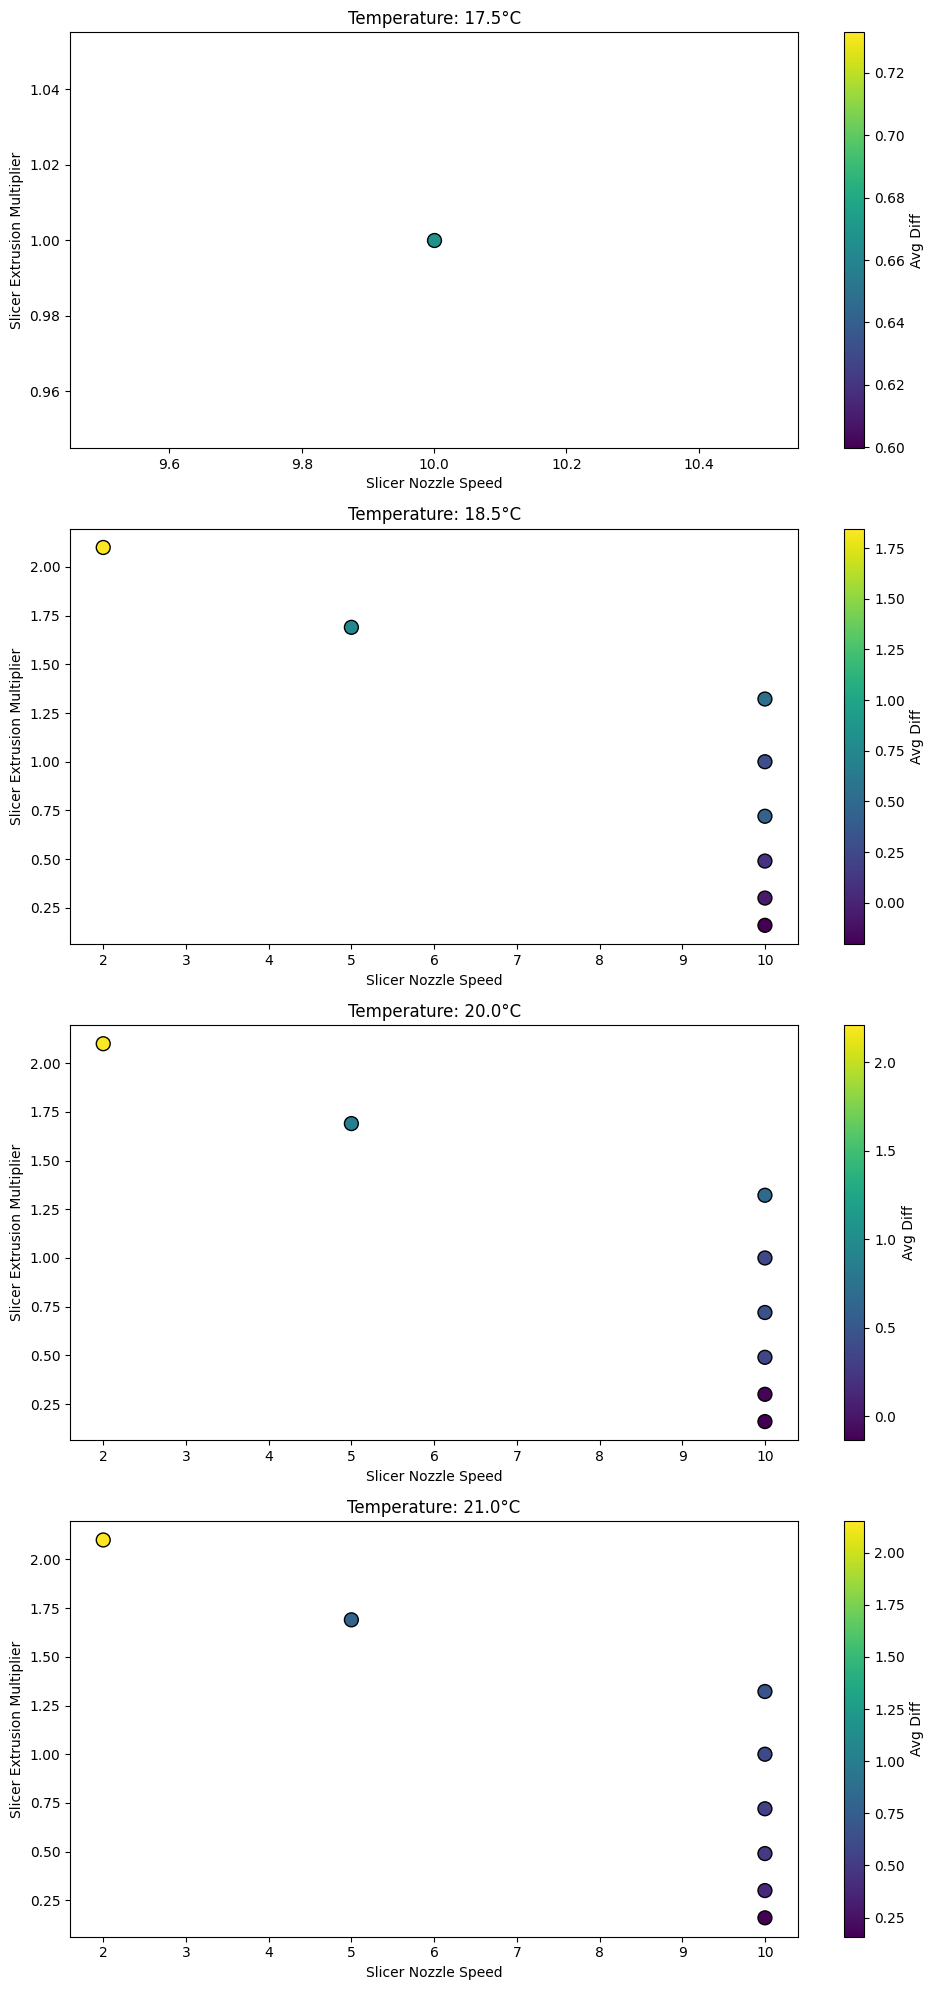

In [6]:
import matplotlib.pyplot as plt

# Group by 'temp', 'slicer_nozzle_speed', and 'slicer_extrusion_multiplier', taking the mean of 'avg_diff'
avg_diff_df = casting_df.groupby(['temp', 'slicer_nozzle_speed', 'slicer_extrusion_multiplier'], as_index=False).mean()

# Get unique temperatures
unique_temps = avg_diff_df['temp'].unique()

# Set up the plot grid
plt.figure(figsize=(10, 5 * len(unique_temps)))

# Create a plot for each unique temp value
for i, temp in enumerate(unique_temps, start=1):
    plt.subplot(len(unique_temps), 1, i)
    
    # Filter DataFrame for the current temp
    temp_df = avg_diff_df[avg_diff_df['temp'] == temp]
    
    # Create scatter plot with color based on 'avg_diff'
    scatter = plt.scatter(
        x=temp_df['slicer_nozzle_speed'],
        y=temp_df['slicer_extrusion_multiplier'],
        c=temp_df['avg_diff'],
        cmap='viridis',
        edgecolor='k',
        s=100
    )
    
    # Set plot title and labels
    plt.title(f'Temperature: {temp}°C')
    plt.xlabel('Slicer Nozzle Speed')
    plt.ylabel('Slicer Extrusion Multiplier')
    
    # Add color bar for 'avg_diff' values
    cbar = plt.colorbar(scatter)
    cbar.set_label('Avg Diff')

# Adjust layout
plt.tight_layout()
plt.show()

In [7]:
print(f"Min and max average height values: {casting_df['height_average'].min()}, {casting_df['height_average'].max()}")
print(f"Min and max average width values: {casting_df['width_average'].min()}, {casting_df['width_average'].max()}")
print(f"\nTarget height = {casting_df['slicer_layer_height'].iloc[0]}, target width = {casting_df['slicer_layer_width'].iloc[0]}")

Min and max average height values: 0.5499999999999999, 2.0666666666666664
Min and max average width values: 1.2666666666666666, 4.973333333333334

Target height = 0.8, target width = 1.5


### Basic models

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error

# Define the input and output variables
X = casting_df[['slicer_nozzle_speed', 'slicer_extrusion_multiplier', 'temp']]
y = casting_df[['height_average', 'width_average']]

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Custom loss function (combined RMSE for both height and width)
def custom_loss(y_true, y_pred):
    width_rmse = np.sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    height_rmse = np.sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))
    return width_rmse + height_rmse

# Wrap the custom loss into a scorer for GridSearchCV
custom_scorer = make_scorer(custom_loss, greater_is_better=False)

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

# GBR
gbr = GradientBoostingRegressor()
gbr_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
gbr_model = {"name": "GBR", "model": gbr, "param_grid": gbr_param_grid}

# GPR
gpr = GaussianProcessRegressor()
gpr_param_grid = {
    'kernel': [j * RBF(length_scale=[i], length_scale_bounds='fixed') for i in [0.1, 0.5, 1, 2, 5, 10] for j in range(1, 5)],
    'alpha': [0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0, 1]
}
gpr_model = {"name": "GPR", "model": gpr, "param_grid": gpr_param_grid}

# SVM
svr = SVR()
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}
svr_model = {"name": "SVM", "model": svr, "param_grid": svr_param_grid}

# Save models
models = (gbr_model, gpr_model, svr_model)

In [10]:
models_predictions = []
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models:

        # Use GridSearchCV with custom scorer to optimize hyperparameters for each target independently
        model_height = GridSearchCV(model["model"], model["param_grid"], cv=cv, scoring=custom_scorer)
        model_width = GridSearchCV(model["model"], model["param_grid"], cv=cv, scoring=custom_scorer)

        # Fit the models separately on the training data
        model_height.fit(X_train, y_train['height_average'])
        model_width.fit(X_train, y_train['width_average'])

        # Extract best estimators from GridSearchCV
        best_model_height = model_height.best_estimator_
        best_model_width = model_width.best_estimator_

        # Final predictions on the data
        val_height_preds = best_model_height.predict(X_val)
        val_width_preds = best_model_width.predict(X_val)
        train_height_preds = best_model_height.predict(X_train)
        train_width_preds = best_model_width.predict(X_train)

        # Store predictions
        models_predictions.append({"name": model["name"],
                                "height_predicted": val_height_preds,
                                "width_predicted": val_width_preds})

        # Evaluate using custom loss on the train + validation set
        train_loss = custom_loss(np.column_stack((y_train['height_average'], y_train['width_average'])),
                                np.column_stack((train_height_preds, train_width_preds)))

        val_loss = custom_loss(np.column_stack((y_val['height_average'], y_val['width_average'])),
                                np.column_stack((val_height_preds, val_width_preds)))

        print(model["name"], "model:")
        print(f"Final combined RMSE (width + height) on train set: {train_loss}")
        print(f"Final combined RMSE (width + height) on validation set: {val_loss}\n")

GBR model:
Final combined RMSE (width + height) on train set: 0.7175533692685909
Final combined RMSE (width + height) on validation set: 0.4802761530842154

GPR model:
Final combined RMSE (width + height) on train set: 0.22675260025433197
Final combined RMSE (width + height) on validation set: 1.5400430768790832

SVM model:
Final combined RMSE (width + height) on train set: 0.5694103991009124
Final combined RMSE (width + height) on validation set: 0.5845812189351269



In [11]:
y_val['height_predicted'] = val_height_preds
y_val['width_predicted'] = val_width_preds

y_val

,height_average,width_average,height_predicted,width_predicted
15,0.740000,1.703333,0.782971,2.496666
42,0.790000,2.513333,0.809638,2.570819
33,0.833333,2.530000,0.809638,2.570819
50,0.883333,2.513333,0.716305,2.311284
19,0.743333,2.353333,0.782971,2.496666
53,1.003333,2.873333,0.716305,2.311284
28,0.676667,2.350000,0.722784,2.321215
27,0.770000,2.413333,0.749927,2.400340
35,0.976667,2.606667,0.809638,2.570819
21,0.763333,2.516667,0.782971,2.496666
